# Notebook 2: Handling Class Imbalanced in Machine Learning via Resampling

### Organized by Chris Monterola, guided by ChatGPT and the following references:


1. https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a (Main Reference: flow, discussions and codes are mainly from this reference)

2. https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/

3. Batista, Gustavo EAPA, Ronaldo C. Prati, and Maria Carolina Monard. “A Study of the Behavior of Several Methods for Balancing Machine Learning Training Data” ACM SIGKDD explorations newsletter 6.1 (2004): 20–29.

4. Chawla, Nitesh V., et al. “SMOTE: synthetic minority over-sampling technique.” Journal of artificial intelligence research 16 (2002): 321–357.


# 1. Introduction

Class imbalance is a common challenge encountered in the field of machine learning when dealing with datasets where one class significantly outnumbers the other(s). In a typical binary classification problem, one class is considered the "positive" or "minority" class, while the other is the "negative" or "majority" class. The class with fewer instances is often of more interest because it represents the target of interest, such as detecting fraudulent transactions, identifying rare diseases, or classifying rare events.

Class imbalance arises from real-world scenarios where certain outcomes or events are rare relative to others. For example,

**Detecting fraudulent credit card transactions:** Genuine transactions vastly outnumber fraudulent ones.    

**Medical diagnosis:** Rare diseases occur less frequently compared to common health conditions.    

**Anomaly detection in manufacturing:** Defective products are a small fraction of the total production.





Why machine learning is compromised by class imbalance?

**1. Model Bias:** Imbalanced datasets can lead to biased models that favor the majority class. Machine learning algorithms tend to learn from the majority class more effectively, resulting in poor predictive performance for the minority class.

**2. Misleading Accuracy:** Traditional accuracy as an evaluation metric can be misleading. A model that predicts the majority class for all instances can achieve high accuracy but provide little practical value.

**3. Costly Errors:** In imbalanced scenarios, misclassifying instances of the minority class can be far more costly or critical than misclassifying majority class instances. For instance, failing to detect a rare disease can have severe consequences.

**4. Data Collection Challenges:** Gathering more data for the minority class can be expensive and time-consuming, making it challenging to balance the dataset.




This notebook will discuss the most common technique to address Class Imbalance, aptly referred to as **Resampling or Rebalancing**. This includes oversampling the minority class by replicating instances (Section 2.1) or Undersampling (Section 2.2) the majority class by removing cases. Other rebalancing techniques like SMOTE (Synthetic Minority Over-sampling Technique, Section 2.3), ADASYN (Adaptive Synthetic, Section 2.4), or Tomek (Named after the one who developed it, Section 2.5) will also be covered. Finally, a combination of oversampling the minority and undersampling the majority (SMOTE-TOMEK) will be described.



# 2. Handling Class imbalanced by Resampling

The Dataset we will be using following Reference 1 is the Communities and Crime Data Set by UCI0 (https://archive.ics.uci.edu/dataset/183/communities+and+crime). It contains 100 attributes of 1994 U.S. communities. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR. We can use this to predict if the crime rate is high (defined as having per capita violent crime above 0.65). The data source is available in the UCI Machine Learning Repository and is created by Michael Redmond from La Salle University (Published in 2009).

In [33]:
#pip install -U imbalanced-learn



The variables included in the dataset involve the community, such as the percent of the population considered urban, and the median family income, and involving law enforcement, such as per capita number of police officers, and percent of officers assigned to drug units.

This dataset is imbalanced. It has 12 communities with low crime rates for every 1 community of high crime rate. This is perfect to illustrate our use case.



In [34]:
from imblearn.datasets import fetch_datasets

In [35]:
us_crime = fetch_datasets()['us_crime']

In [36]:
us_crime

{'data': array([[0.19, 0.33, 0.02, ..., 0.26, 0.2 , 0.32],
        [0.  , 0.16, 0.12, ..., 0.12, 0.45, 0.  ],
        [0.  , 0.42, 0.49, ..., 0.21, 0.02, 0.  ],
        ...,
        [0.16, 0.37, 0.25, ..., 0.32, 0.18, 0.91],
        [0.08, 0.51, 0.06, ..., 0.38, 0.33, 0.22],
        [0.2 , 0.78, 0.14, ..., 0.3 , 0.05, 1.  ]]),
 'target': array([-1,  1, -1, ..., -1, -1, -1]),
 'DESCR': 'us_crime'}

We will convert this dictionary to a Pandas dataframe, then split it into train-test splits.

In [37]:
import pandas as pd


# Convert the dictionary to a pandas dataframe
crime_df = pd.concat([pd.DataFrame(us_crime['data'], columns = [f'data_{i}' for i in range(us_crime.data.shape[1])]),
           pd.DataFrame(us_crime['target'], columns = ['target'])], axis = 1)

# Split data into train test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(crime_df.drop('target', axis = 1),
                                                    crime_df['target'],
                                                    test_size = 0.4,
                                                    random_state = 42)

In [38]:
crime_df

data_0  data_1  data_2  data_3  data_4  data_5  data_6  data_7  data_8  \
0       0.19    0.33    0.02    0.90    0.12    0.17    0.34    0.47    0.29   
1       0.00    0.16    0.12    0.74    0.45    0.07    0.26    0.59    0.35   
2       0.00    0.42    0.49    0.56    0.17    0.04    0.39    0.47    0.28   
3       0.04    0.77    1.00    0.08    0.12    0.10    0.51    0.50    0.34   
4       0.01    0.55    0.02    0.95    0.09    0.05    0.38    0.38    0.23   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1989    0.01    0.40    0.10    0.87    0.12    0.16    0.43    0.51    0.35   
1990    0.05    0.96    0.46    0.28    0.83    0.32    0.69    0.86    0.73   
1991    0.16    0.37    0.25    0.69    0.04    0.25    0.35    0.50    0.31   
1992    0.08    0.51    0.06    0.87    0.22    0.10    0.58    0.74    0.63   
1993    0.20    0.78    0.14    0.46    0.24    0.77    0.50    0.62    0.40   

      data_9  ...  data_91  data_92  data_93  data_94  data_95  data_96  \
0       0.32  ...     0.12     0.42     0.50     0.51     0.64     0.12   
1       0.27  ...     0.21     0.50     0.34     0.60     0.52     0.02   
2       0.32  ...     0.14     0.49     0.54     0.67     0.56     0.01   
3       0.21  ...     0.19     0.30     0.73     0.64     0.65     0.02   
4       0.36  ...     0.11     0.72     0.64     0.61     0.53     0.04   
...      ...  ...      ...      ...      ...      ...      ...      ...   
1989    0.30  ...     0.22     0.28     0.34     0.48     0.39     0.01   
1990    0.14  ...     0.53     0.25     0.17     0.10     0.00     0.02   
1991    0.54  ...     0.25     0.68     0.61     0.79     0.76     0.08   
1992    0.41  ...     0.45     0.64     0.54     0.59     0.52     0.03   
1993    0.17  ...     0.68     0.50     0.34     0.35     0.68     0.11   

      data_97  data_98  data_99  target  
0        0.26     0.20     0.32      -1  
1        0.12     0.45     0.00       1  
2        0.21     0.02     0.00      -1  
3        0.39     0.28     0.00      -1  
4        0.09     0.02     0.00      -1  
...       ...      ...      ...     ...  
1989     0.28     0.05     0.00      -1  
1990     0.37     0.20     0.00      -1  
1991     0.32     0.18     0.91      -1  
1992     0.38     0.33     0.22      -1  
1993     0.30     0.05     1.00      -1  

[1994 rows x 101 columns]

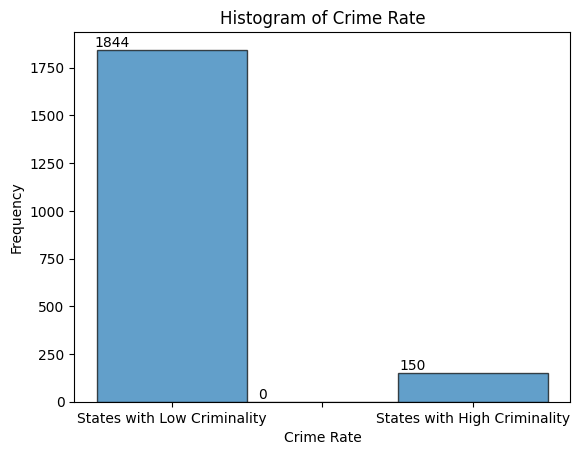

In [39]:
import matplotlib.pyplot as plt
import numpy as np

target_values = us_crime['target']

# Define bin edges and labels
bin_edges = [-1.5, -0.5, 0.5, 1.5]
bin_labels = ['', 'States with Low Criminality', 'States with High Criminality']

# Create a histogram with custom bin edges and labels
plt.hist(target_values, bins=bin_edges, edgecolor='black', alpha=0.7)

# Replace the x-axis labels with custom labels
plt.xticks([0, -1, 1], bin_labels)

# Add labels and title
plt.xlabel('Crime Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Crime Rate')

# Add frequency counts on top of the bars
hist, bins = np.histogram(target_values, bins=bin_edges)
for i, count in enumerate(hist):
    plt.text(bins[i] + 0.1, count + 1, str(count), va='bottom', ha='center')

# Show the plot
plt.show()


The attributes of **data_i** can be inferred by looking at the UCI website cited above. Note that we will only perform under- and over-sampling only on the train dataset. We will not change the test sets with under- and over-sampling to gauge the impact of data rebalancing techniques.

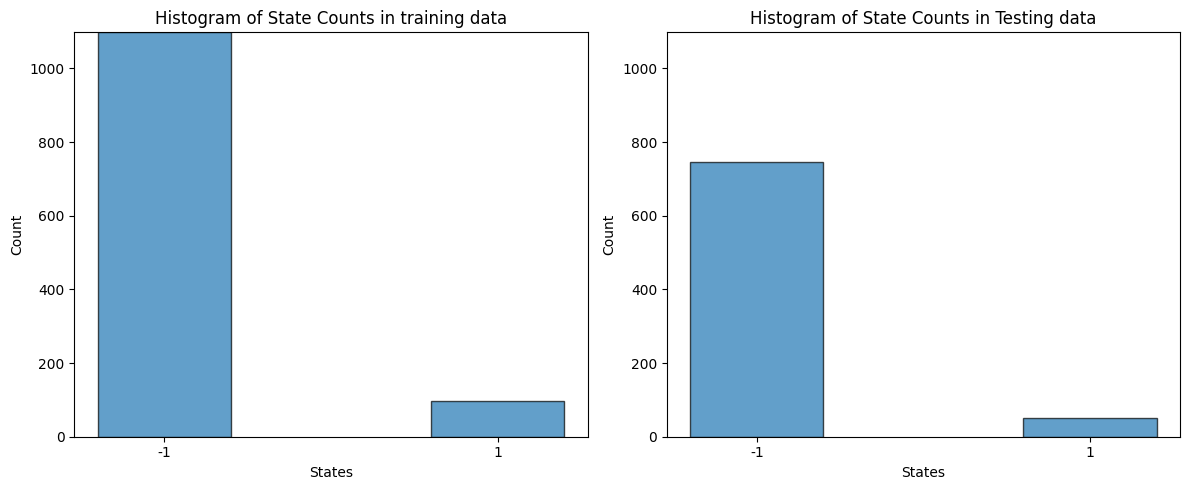

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_train and y_train_rus are your arrays
unique_states_train, state_counts_train = np.unique(y_train, return_counts=True)
unique_states_rus, state_counts_rus = np.unique(y_test, return_counts=True)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Calculate the maximum count to set the same y-axis limit for both subplots
max_count = max(state_counts_train.max(), state_counts_rus.max())

# Plot the histogram of y_train on the left subplot
ax1.bar(unique_states_train, state_counts_train, tick_label=unique_states_train, edgecolor='black', alpha=0.7)
ax1.set_xlabel('States')
ax1.set_ylabel('Count')
ax1.set_title('Histogram of State Counts in training data')
ax1.set_ylim(0, max_count)  # Set the same y-axis limit

# Plot the histogram of y_train_rus on the right subplot
ax2.bar(unique_states_rus, state_counts_rus, tick_label=unique_states_rus, edgecolor='black', alpha=0.7)
ax2.set_xlabel('States')
ax2.set_ylabel('Count')
ax2.set_title('Histogram of State Counts in Testing data')
ax2.set_ylim(0, max_count)  # Set the same y-axis limit

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Preprocessing the dataset

Our goal is to have a visualize an imbalanced dataset. In order to visualize the 128-dimensional dataset in a 2D graph, we do the following on the train set.

We scale the dataset andperform Principle Component Analysis (PCA) on the features to **convert the 100 features to 2 principal components**, visualize the data.

Here’s the data, visualized in 2D.

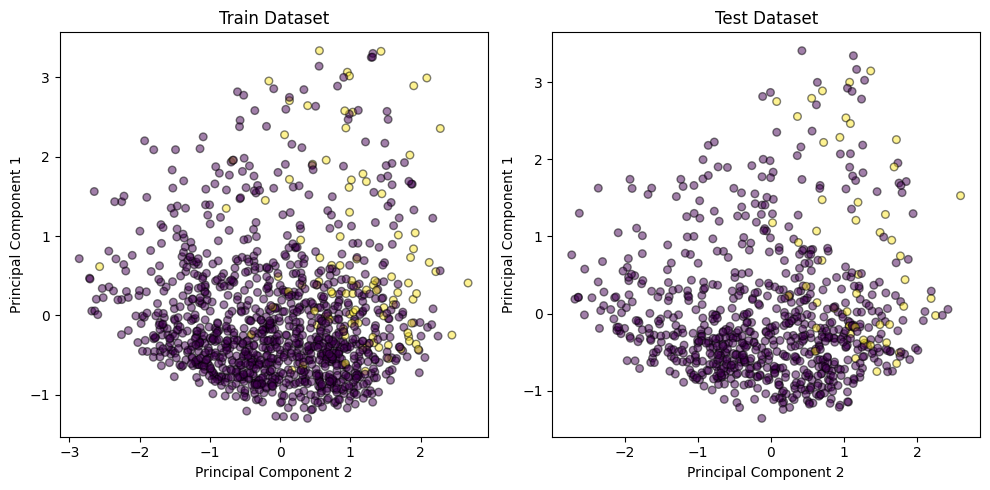

In [41]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Scale the dataset on both train and test sets.
# Note that we fit MinMaxScaler on X_train only, not on the entire dataset.
# This prevents data leakage from test set to train set.
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Perform PCA Decomposition on both train and test sets
# Note that we fit PCA on X_train only, not on the entire dataset.
# This prevents data leakage from test set to train set.
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Function for plotting dataset
def plot_data(X,y,ax,title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s = 30, edgecolor=(0,0,0,0.5))
    ax.set_ylabel('Principal Component 1')
    ax.set_xlabel('Principal Component 2')
    if title is not None:
        ax.set_title(title)

# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the Train dataset on the left subplot
plot_data(X_train_pca, y_train, ax1, title='Train Dataset')

# Plot the Test dataset on the right subplot
plot_data(X_test_pca, y_test, ax2, title='Test Dataset')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()







With the preprocessing done, we are ready to resample our dataset.

#2.1. Random Oversampling

Random oversampling duplicates existing examples from the minority class with replacement. Each data point in the minority class has an equal probability of being duplicated.

Here’s how to we can perform oversampling on our dataset.



In [42]:
from imblearn.over_sampling import RandomOverSampler

# Perform random oversampling
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train_pca, y_train)

Let’s compare the data before (left) and after (right) random oversampling.

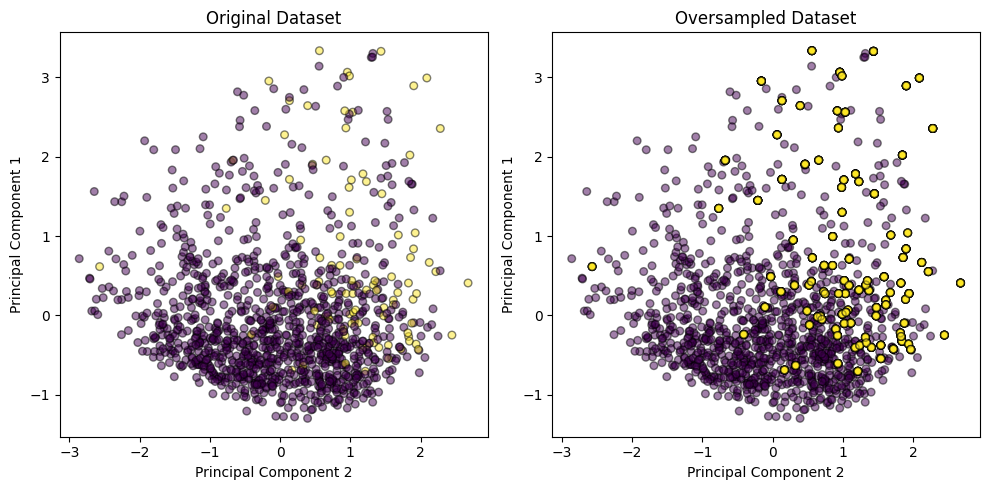

In [43]:
import matplotlib.pyplot as plt

# Function for plotting dataset
def plot_data(X, y, ax, title):
    ax.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5, s=30, edgecolor=(0, 0, 0, 0.5))
    ax.set_ylabel('Principal Component 1')
    ax.set_xlabel('Principal Component 2')
    if title is not None:
        ax.set_title(title)

# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original dataset on the left subplot
plot_data(X_train_pca, y_train, ax1, title='Original Dataset')

# Plot the oversampled dataset on the right subplot
plot_data(X_train_ros, y_train_ros, ax2, title='Oversampled Dataset')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


The only difference? After random oversampling, there are more overlapping data points in the minority class. As a result, the data points of the minority class appear darker.



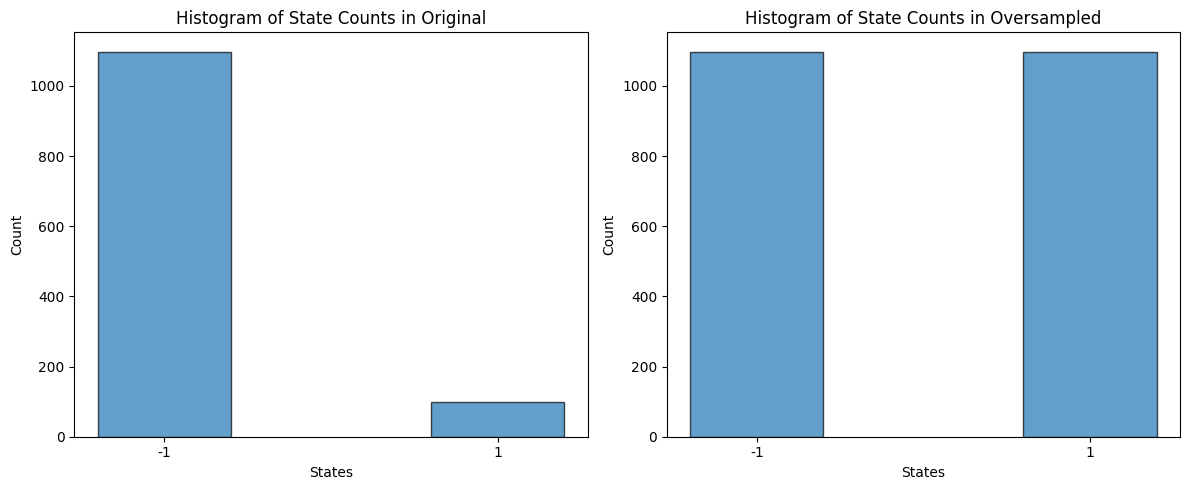

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_train and y_train_ros are your arrays
unique_states_train, state_counts_train = np.unique(y_train, return_counts=True)
unique_states_ros, state_counts_ros = np.unique(y_train_ros, return_counts=True)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the histogram of y_train on the left subplot
ax1.bar(unique_states_train, state_counts_train, tick_label=unique_states_train, edgecolor='black', alpha=0.7)
ax1.set_xlabel('States')
ax1.set_ylabel('Count')
ax1.set_title('Histogram of State Counts in Original')

# Plot the histogram of y_train_ros on the right subplot
ax2.bar(unique_states_ros, state_counts_ros, tick_label=unique_states_ros, edgecolor='black', alpha=0.7)
ax2.set_xlabel('States')
ax2.set_ylabel('Count')
ax2.set_title('Histogram of State Counts in Oversampled')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [45]:

num_elements_ros = len(y_train_ros)
num_elements_train = len(y_train)

print("Number of elements in Oversampled:", num_elements_ros)
print("Number of elements in Orginal:", num_elements_train)


Number of elements in Oversampled: 2196
Number of elements in Orginal: 1196



#2.2. Random Undersampling

Conversely, random undersampling removes existing samples from the majority class. Each data point in the majority class has an equal chance of being removed.

We can do this with the following code.

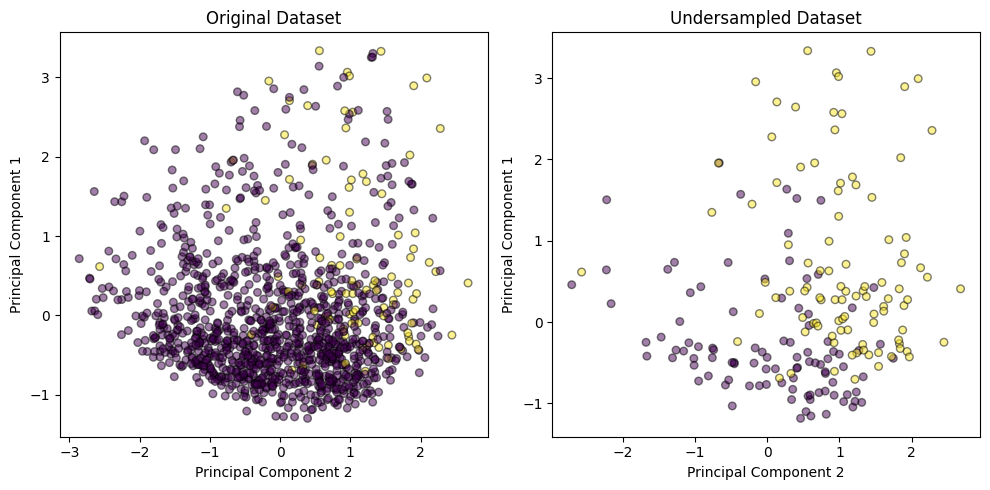

In [46]:
from imblearn.under_sampling import RandomUnderSampler

# Perform random sampling
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train_pca, y_train)

# Create a single figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original dataset on the left subplot
plot_data(X_train_pca, y_train, ax1, title='Original Dataset')

# Plot the undersampled dataset on the right subplot
plot_data(X_train_rus, y_train_rus, ax2, title='Undersampled Dataset')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


Now, let's apply machine learning to under- and over-sampled sets Let’s compare the performance of a classification machine learning model (SVM model) trained on three datasets above (unmodified, under- dataset, and over-sampled dataset)

Here, we train three Support Vector Machine Classifiers (SVC) with default settings on three datasets:

Original data


Randomly over-sampled data

randomly under-sampled data


In [47]:
from sklearn.svm import SVC

# Train SVC on original data
clf = SVC(kernel='linear',probability=True)
clf.fit(X_train_pca, y_train)

# Train SVC on randomly oversampled data
clf_ros = SVC(kernel='linear',probability=True)
clf_ros.fit(X_train_ros, y_train_ros)

# Train SVC on randomly undersampled data
clf_rus = SVC(kernel='linear',probability=True)
clf_rus.fit(X_train_rus, y_train_rus)

# Function for plotting is in Notebook.
# Insert link here.

SVC(kernel='linear', probability=True)

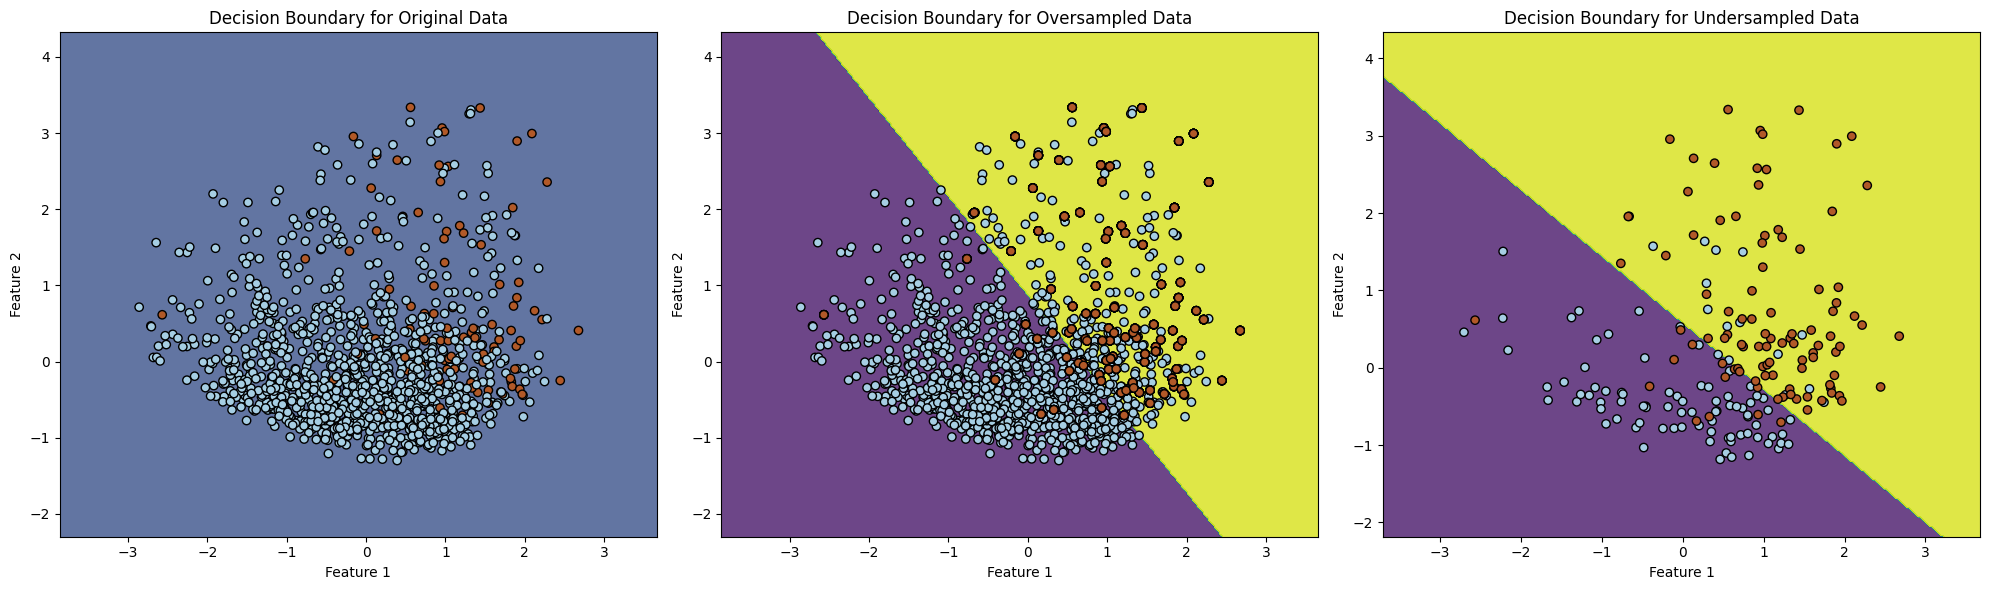

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, ax, title="Decision Boundary"):
    # Create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plotting decision boundaries
plot_decision_boundary(clf, X_train_pca, y_train, axes[0], "Decision Boundary for Original Data")
plot_decision_boundary(clf_ros, X_train_ros, y_train_ros, axes[1], "Decision Boundary for Oversampled Data")
plot_decision_boundary(clf_rus, X_train_rus, y_train_rus, axes[2], "Decision Boundary for Undersampled Data")

# Show the plots
plt.tight_layout()
plt.show()


Then, we can visualize what each SVC has learnt from the dataset.



The graphs above summarize what the algorithms have learnt from the dataset. In particular, they have learned that:

A new point falls that falls into the yellow region is predicted as a yellow point (*High crime rate community*)

A new point falls that falls into the purple region is predicted as a purple point (*Low crime rate community*)

Here are some observations:

The SVC trained on the original dataset is… quite useless. It essentially predicts all communities as purple. It learns to ignore all yellow points.

The SVCs trained on oversampled and undersampled datasets are less biased. They are less likely to call misclassfy the minority class.
The decision boundaries of SVCs trained on over-sampled and under-sampled dataset differ.

###Using ROC to evaluate resampled models

To evaluate which SVC is the best, we will have to evaluate the performance of the SVCs on a test set. The metric that we will use is the receiver operating curve (ROC) to find the area under curve (AUC).

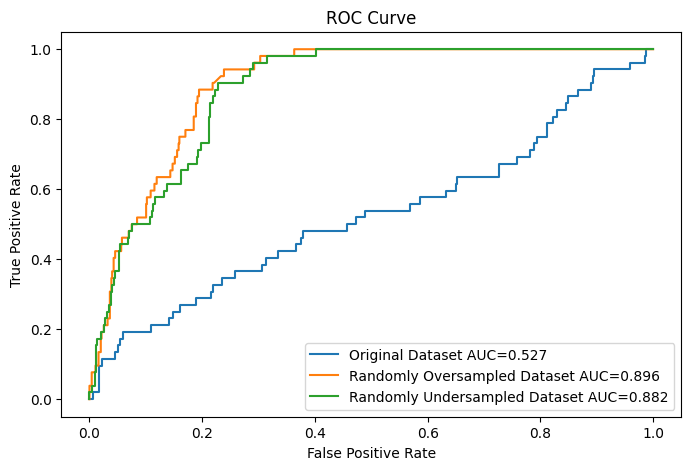

In [49]:
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt

# Helper function for plotting ROC
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    clf = SVC(kernel='linear',probability=True)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict_proba(X_test)[:,1]

    #Note that we only use the ROC curve for the test set
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    ax.plot(fpr,tpr,label=f"{title} AUC={auc:.3f}")

    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc=0)

# Plot all ROC into one graph

fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_pca, y_train, X_test_pca, y_test, 'Original Dataset')
plot_roc(ax, X_train_ros, y_train_ros, X_test_pca, y_test, 'Randomly Oversampled Dataset')
plot_roc(ax, X_train_rus, y_train_rus, X_test_pca, y_test, 'Randomly Undersampled Dataset')

The SVC trained on the original data performed poorly. It did worse than if we were to randomly guess the output.

The randomly oversampled dataset outperformed the under-sampled dataset. One possible reason is that there is a loss of information from removing data points from the undersampling procedure. Conversely, no information is lost from oversampling the data.

Now that we have an understanding of oversampling and undersampling, let’s delve deeper into oversampling and undersampling techniques.



# 2.3 Oversampling with SMOTE

Synthetic Minority Oversampling Technique or **SMOTE** is a method of oversampling. Intuitively, **SMOTE** creates synthetic data points by interpolating between the minority data points that are close by to one another.

Here’s how SMOTE works (simplified).

1. Randomly select some data points in the minority class.
2. For every selected point, identify its k nearest neighbour(s).
3. For every neighbor, add a new point somewhere between the data point and the neighbor.

Repeat steps 2 to 4 until sufficient synthetic data points are created.



In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC

# Perform random sampling
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

# Train linear SVC
clf_smote = SVC(kernel='linear',probability=True)
clf_smote.fit(X_train_smote, y_train_smote)

SVC(kernel='linear', probability=True)

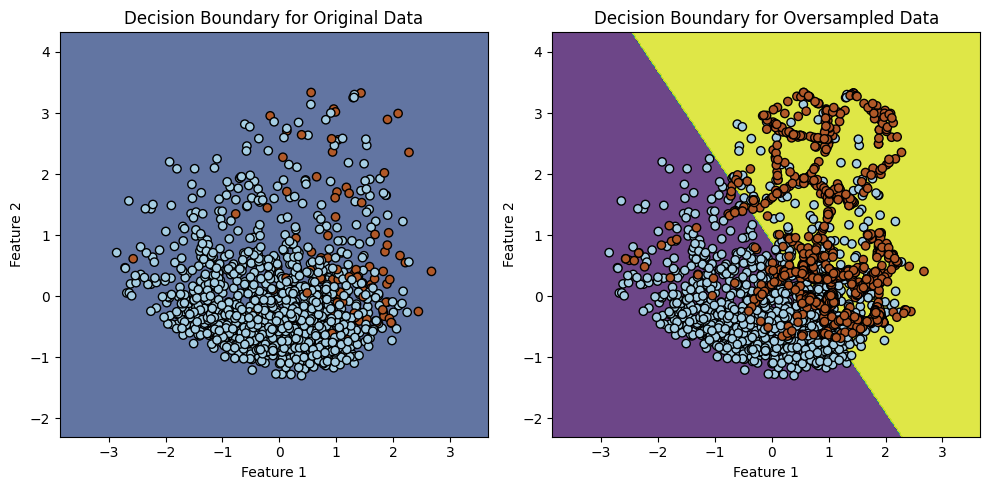

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, ax, title="Decision Boundary"):
    # Create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotting decision boundaries
plot_decision_boundary(clf, X_train_pca, y_train, axes[0], "Decision Boundary for Original Data")
plot_decision_boundary(clf_smote, X_train_smote, y_train_smote, axes[1], "Decision Boundary for Oversampled Data")


# Show the plots
plt.tight_layout()
plt.show()

Note that Feature i is the same as Principal Component i.

# 2.4 Oversampling with ADASYN

Adaptive Synthetic or ADASYN is a cousin of SMOTE: both SMOTE and ADASYN generate new samples by interpolation.

But there’s on critical difference. ADASYN generates samples next to the original samples that are wrongly classified by a KNN classifier. Conversely, SMOTE differentiates between samples that are correctly or wrongly classified by the KNN classifier.

Similar to SMOTE, ADASYN creates "synthetic" examples using the points between two neighboring minority samples. ADASYN however employs a weighted distribution of the minority class examples according to level of difficulty of learning. This weighted distribution is determined by the number of majority classes in the $K$ neighborhood of a minority sample.



**Algorithm:**

1. Caculate `d`: $d = m_s / m_l$ where $m_s$ and $m_l$ are the number of samples in the minority and majority class respectively.
2. Check if class ratio `d` is below the acceptable threshold `d_tresh`. If yes, proceed with the next steps.
3. Determine the number of samples `G` to add using: $G = (m_l - m_s) * \beta$, where $\beta$ is the preferred class ratio after resampling. $\beta = 1$ means a perfect balance.
4. Get the nearest `n_neighbors` of each minority class sample.
5. Get the ratio $r_i$ of $m_l$ and `n_neighbors` ($K$) for each minority class sample neighborhood. $r_i = m_l / K$
6. Normalize the $r_i$ to obtain a density distribution.
7. Use the density distribution to get the number of synthetic samples $g$ to be generated per minority class. $g = r_i * G$
8. Generate $g$ samples per original minority class sample using the following algorithm:
    * Select a random minority class sample within the neighborhood of the sample of interest
    * Generate synthetic data using the formula: $s = x + (x_z - x) * \lambda$ where $s$ is the synthetic data, $x$ reference sample (of interest), $xz$ neighboring minority class sample, and $\lambda$ as a random weighting factor to the element-wise difference $(x_z - x)$. *Similar algorithm with SMOTE*
    * Repeat $g$ times for each minority class sample, collecting the new synthetic data at each time.
9. Add the synthetic data to the training data used as input, `feature_frame`.

In [52]:
from imblearn.over_sampling import ADASYN

# Perform random sampling
adasyn = ADASYN(random_state=0)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_pca, y_train)

# Train linear SVC
from sklearn.svm import SVC
clf_adasyn = SVC(kernel='linear',probability=True)
clf_adasyn.fit(X_train_adasyn, y_train_adasyn)

SVC(kernel='linear', probability=True)

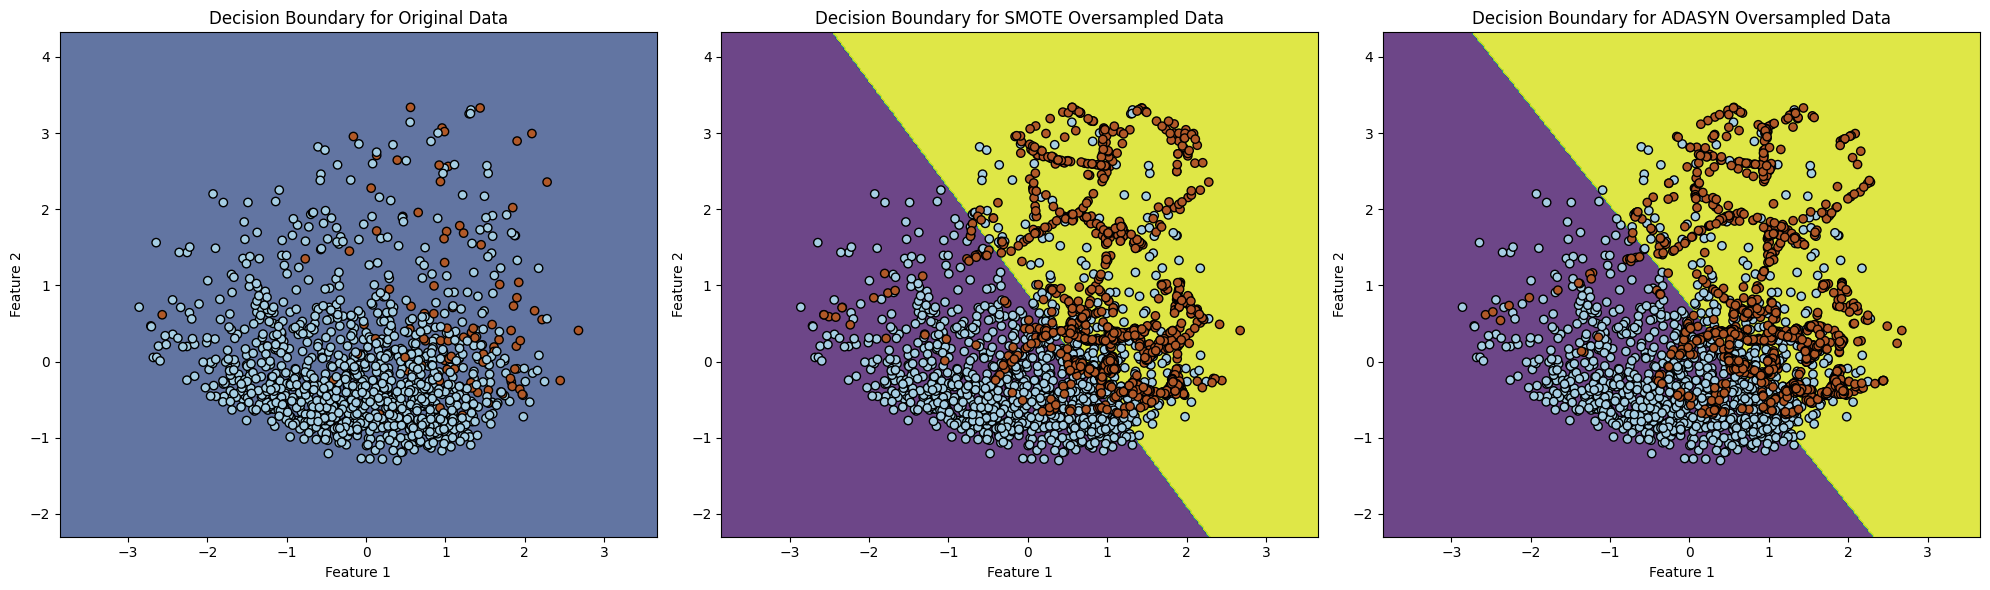

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, ax, title="Decision Boundary"):
    # Create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plotting decision boundaries
plot_decision_boundary(clf, X_train_pca, y_train, axes[0], "Decision Boundary for Original Data")
plot_decision_boundary(clf_smote, X_train_smote, y_train_smote, axes[1], "Decision Boundary for SMOTE Oversampled Data")
plot_decision_boundary(clf_adasyn, X_train_adasyn, y_train_adasyn, axes[2], "Decision Boundary for ADASYN Oversampled Data")

# Show the plots
plt.tight_layout()
plt.show()

Here are a few observations.

First, both over-sampling approaches cause more synthetic data points to be created in between original data points. That’s because both SMOTE and ADASYN use interpolation to create new data points.

Second, comparing SMOTE and ADASYN, we notice ADASYN creates data points for minority (yellow) points near the majority (purple) data points.

Let’s compare the ROC of all over-sampling methods we have described so far. In this example, they perform equally well.

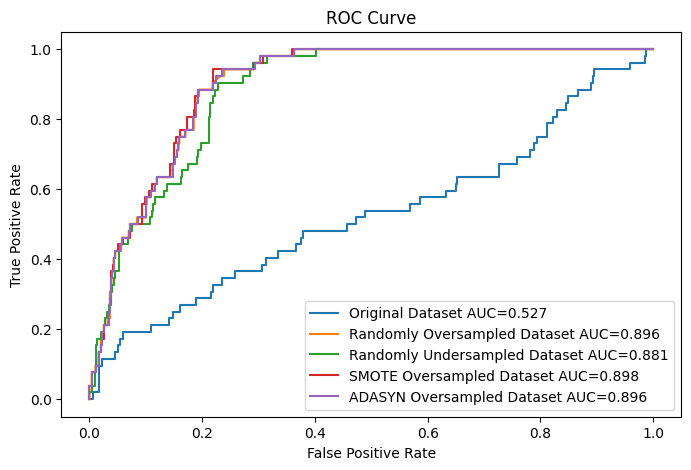

In [54]:
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt

# Helper function for plotting ROC
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    clf = SVC(kernel='linear',probability=True)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict_proba(X_test)[:,1]

    #Note that we only use the ROC curve for the test set
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    ax.plot(fpr,tpr,label=f"{title} AUC={auc:.3f}")

    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc=0)

# Plot all ROC into one graph

fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_pca, y_train, X_test_pca, y_test, 'Original Dataset')
plot_roc(ax, X_train_ros, y_train_ros, X_test_pca, y_test, 'Randomly Oversampled Dataset')
plot_roc(ax, X_train_rus, y_train_rus, X_test_pca, y_test, 'Randomly Undersampled Dataset')
plot_roc(ax, X_train_smote, y_train_smote, X_test_pca, y_test, 'SMOTE Oversampled Dataset')
plot_roc(ax, X_train_adasyn, y_train_adasyn, X_test_pca, y_test, 'ADASYN Oversampled Dataset')


The above results indicate that oversampling is the way to go. The rule of thumb is you need more than 1000 data points of a represented data set, and undersampling to just around 200 data points will compromise the model's accuracy.

# 2.5 Under-sampling with Tomek Links
A tomek link is a pair of points that are very close to one another but are of different classes. Under-sampling proceeds by removing the majority class that belongs to Tomek link.



Tomek Links is one of a modification from Condensed Nearest Neighbors (CoNN) undersampling technique that is developed by Tomek (1976). Unlike the CoNN method that are only randomly select the samples with its k nearest neighbors from the majority class that wants to be removed, the Tomek Links method uses the rule to selects the pair of observation (say, a and b) that are fulfilled these properties:

The observation a’s nearest neighbor is b.

The observation b’s nearest neighbor is a.

Observation a and b belong to a different class. That is, a and b belong to the minority and majority class (or vice versa), respectively.

Mathematically, it can be expressed as follows:

Let $d(x_i, x_j)$ denotes the Euclidean distance between $x_i$ and $x_j$, where $x_i$ denotes sample that belongs to the minority class and $x_j$ denotes sample that belongs to the majority class. If there is no sample $x_k$ satisfies the following condition: $ d(x_i, x_k) < d(x_i, x_j),$ or $d(x_j, x_k) < d(x_i, x_j)$ then the pair of $(x_i, x_j)$ is a Tomek Link.

To under-sample with Tomek Links, we will identify all Tomek Links in the data set. For each pair of data point in the Tomek Link, we will remove the majority class.



Material is from: https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc





In [55]:
from imblearn.under_sampling import TomekLinks
from sklearn.svm import LinearSVC

# Perform Tomek Link undersampling
#tomek = TomekLinks(sampling_strategy=0.8)
tomek = TomekLinks()
X_train_tomek, y_train_tomek = tomek.fit_resample(X_train_pca, y_train)

# Train linear SVC
clf_tomek = SVC(kernel='linear',probability=True)
clf_tomek.fit(X_train_tomek, y_train_tomek)

SVC(kernel='linear', probability=True)

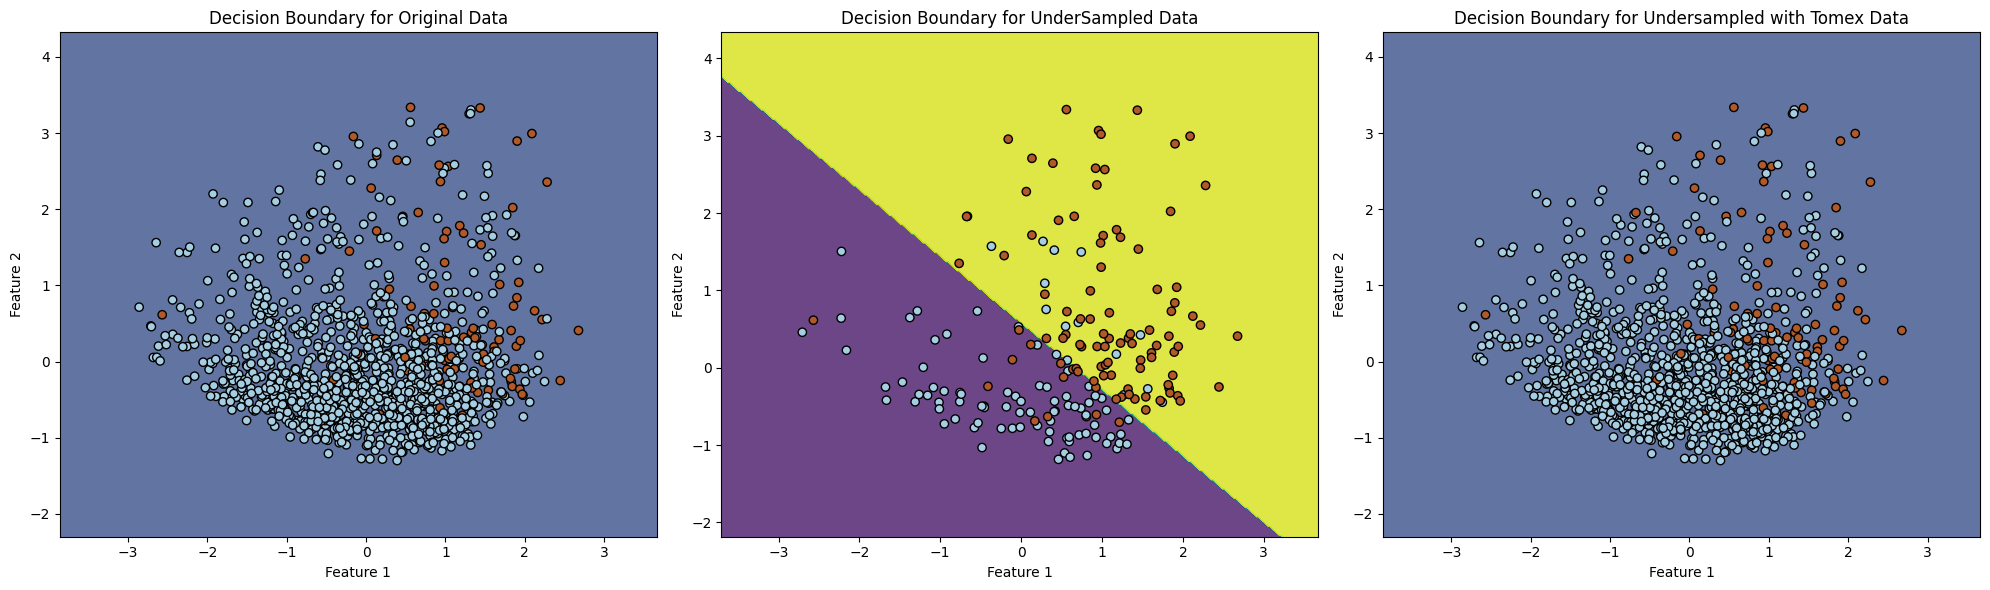

In [56]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, ax, title="Decision Boundary"):
    # Create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plotting decision boundaries
plot_decision_boundary(clf, X_train_pca, y_train, axes[0], "Decision Boundary for Original Data")
plot_decision_boundary(clf_rus, X_train_rus, y_train_rus, axes[1], "Decision Boundary for UnderSampled Data")
plot_decision_boundary(clf_tomek, X_train_tomek, y_train_tomek, axes[2], "Decision Boundary for Undersampled with Tomex Data")

# Show the plots
plt.tight_layout()
plt.show()

In our particular dataset, removing Tomek Link did little to ease the class imbalance. This is because there are limited number of Tomek Links in the dataaset.

Let’s see how the performance of undersampling with Tomek Link differs from that of random undersampling.

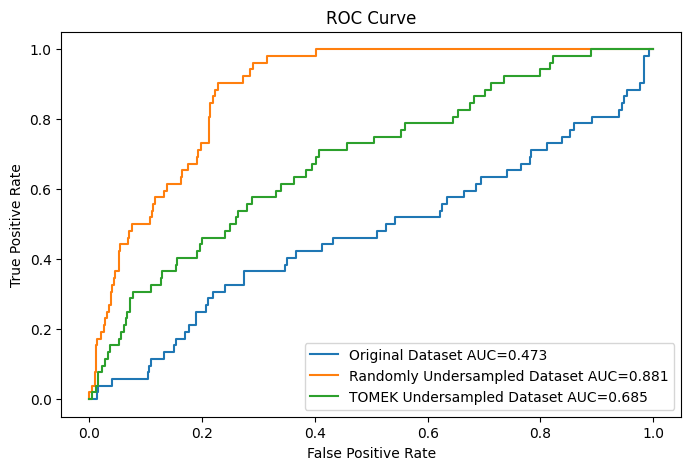

In [57]:
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt

# Helper function for plotting ROC
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    clf = SVC(kernel='linear',probability=True)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict_proba(X_test)[:,1]

    #Note that we only use the ROC curve for the test set
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    ax.plot(fpr,tpr,label=f"{title} AUC={auc:.3f}")

    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc=0)

# Plot all ROC into one graph

fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_pca, y_train, X_test_pca, y_test, 'Original Dataset')
plot_roc(ax, X_train_rus, y_train_rus, X_test_pca, y_test, 'Randomly Undersampled Dataset')
plot_roc(ax, X_train_tomek, y_train_tomek, X_test_pca, y_test, 'TOMEK Undersampled Dataset')


We observe that random undersampling did better than Tomek Link undersampling. This is because Tomek Link did not remove the class imbalance completely like random undersampling did.

#2.6 SMOTEK: Oversample with SMOTE, then Undersample with Tomek Links

SMOTE-TOMEK is a technique that combines oversampling (SMOTE) with undersampling (with Tomek Links).

In [58]:
from imblearn.combine import SMOTETomek
from sklearn.svm import LinearSVC

# Perform random sampling
smotetomek = SMOTETomek(random_state=0)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_pca, y_train)

# Plot linear SVC
clf_smotetomek = SVC(kernel='linear',probability=True)
clf_smotetomek.fit(X_train_smotetomek, y_train_smotetomek)

SVC(kernel='linear', probability=True)

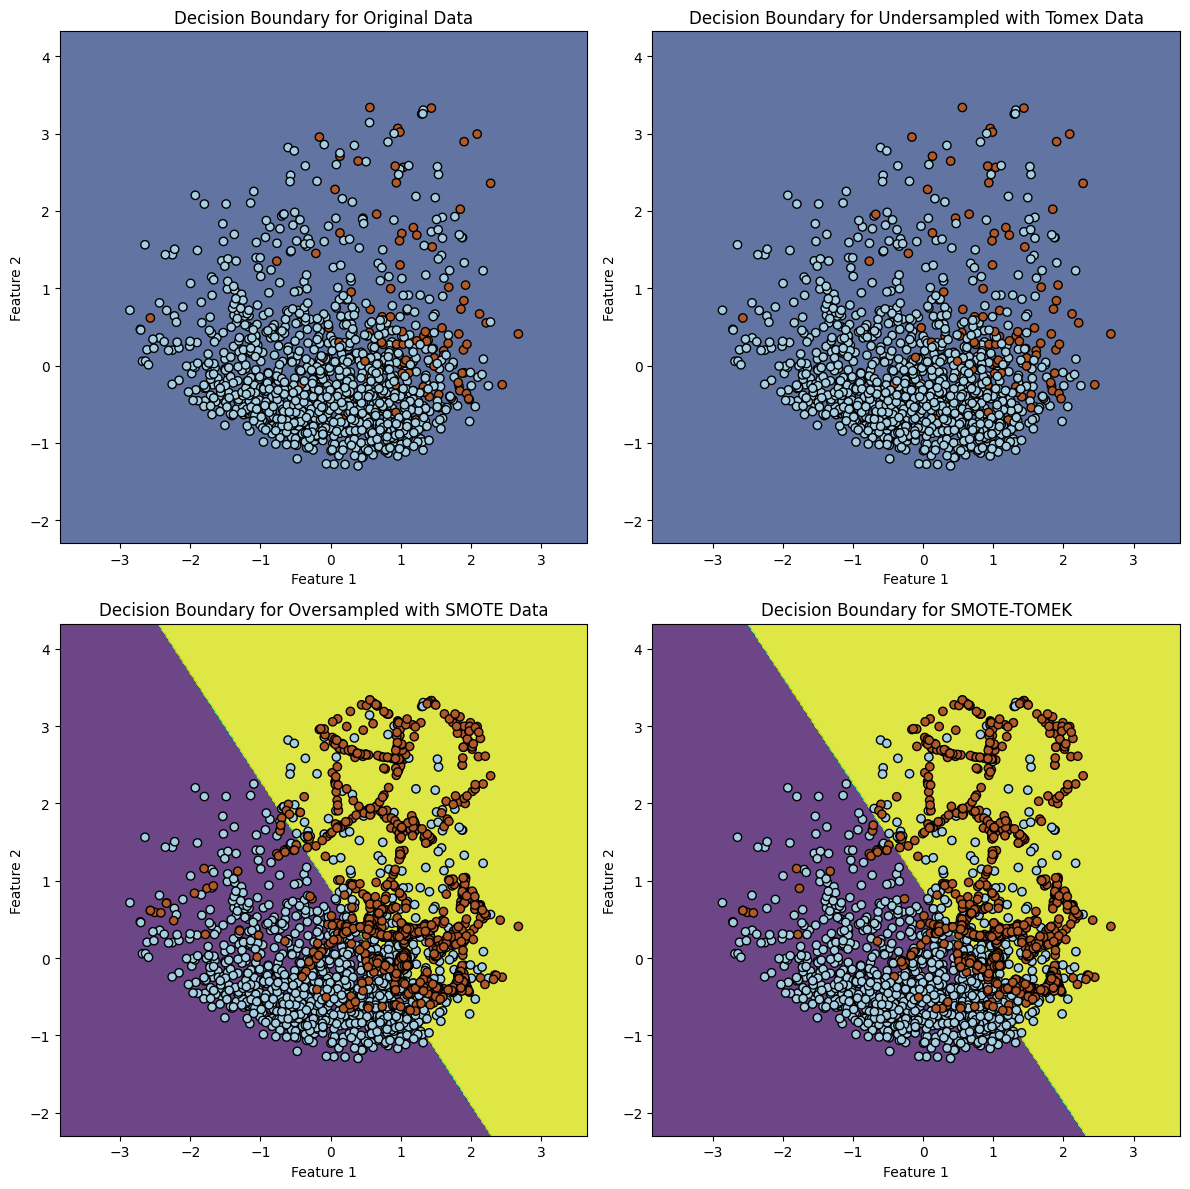

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, ax, title="Decision Boundary"):
    # Create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(title)

# Create a figure with subplots
#fig, axes = plt.subplots(1, 4, figsize=(20, 6))
fig, axes = plt.subplots(2, 2, figsize=(12, 12))


# Plotting decision boundaries
plot_decision_boundary(clf, X_train_pca, y_train, axes[0,0], "Decision Boundary for Original Data")
plot_decision_boundary(clf_tomek, X_train_tomek, y_train_tomek, axes[0,1], "Decision Boundary for Undersampled with Tomex Data")
plot_decision_boundary(clf_smote, X_train_smote, y_train_smote, axes[1,0], "Decision Boundary for Oversampled with SMOTE Data")
plot_decision_boundary(clf_smotetomek, X_train_smotetomek, y_train_smotetomek, axes[1,1], "Decision Boundary for SMOTE-TOMEK")

# Show the plots
plt.tight_layout()
plt.show()

# 2.7 Comparison of 6 Standard Rebalancing Methods

Let's compare now all the 6 rebalancing methods we have described above.

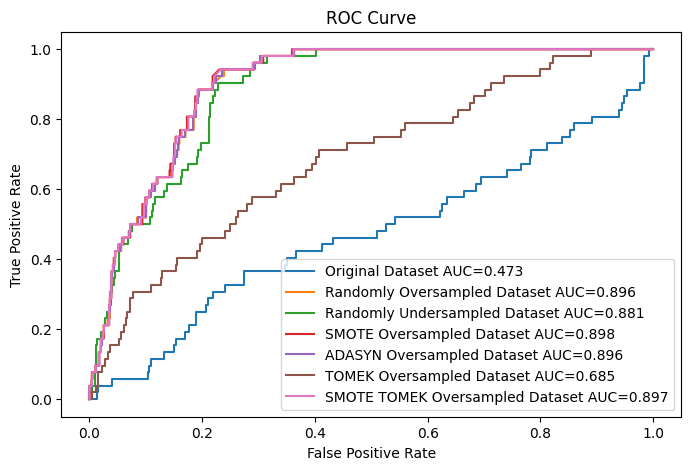

In [60]:
from sklearn.svm import SVC
from sklearn import metrics
import matplotlib.pyplot as plt

# Helper function for plotting ROC
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    clf = SVC(kernel='linear',probability=True)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict_proba(X_test)[:,1]

    #Note that we only use the ROC curve for the test set
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    ax.plot(fpr,tpr,label=f"{title} AUC={auc:.3f}")

    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc=0)

# Plot all ROC into one graph

fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_pca, y_train, X_test_pca, y_test, 'Original Dataset')
plot_roc(ax, X_train_ros, y_train_ros, X_test_pca, y_test, 'Randomly Oversampled Dataset')
plot_roc(ax, X_train_rus, y_train_rus, X_test_pca, y_test, 'Randomly Undersampled Dataset')
plot_roc(ax, X_train_smote, y_train_smote, X_test_pca, y_test, 'SMOTE Oversampled Dataset')
plot_roc(ax, X_train_adasyn, y_train_adasyn, X_test_pca, y_test, 'ADASYN Oversampled Dataset')
plot_roc(ax, X_train_tomek, y_train_tomek, X_test_pca, y_test, 'TOMEK Oversampled Dataset')
plot_roc(ax, X_train_smotetomek, y_train_smotetomek, X_test_pca, y_test, 'SMOTE TOMEK Oversampled Dataset')

At least for this data, oversampling is the way to go, and other additional processes (e.g. SMOTE, ADASYN) will not contribute significantly to the resulting accuracy. We summarize below how many are the final population of each of the states of the training class for the resampling techniques we described above.

In [61]:
#pip install tabulate


In [62]:
import pandas as pd
from tabulate import tabulate

datasets = {
    'y_train': y_train,
    'y_train_ros': y_train_ros,
    'y_train_rus': y_train_rus,
    'y_train_smote': y_train_smote,
    'y_train_adasyn': y_train_adasyn,
    'y_train_tomek': y_train_tomek,
    'y_train_smotetomek': y_train_smotetomek
}

# Create a DataFrame to store counts
count_data = {}

# Count the occurrences of states for each dataset
for dataset_name, dataset in datasets.items():
    count_data[dataset_name] = pd.Series(dataset).value_counts().sort_index()

# Create a DataFrame with dataset names as columns
count_df = pd.DataFrame(count_data)

# Rename the index for better clarity
count_df.index = ['Low Criminality', 'High Criminality']

# Transpose the DataFrame to have rows as counts of states
count_table = count_df.T

# Use tabulate to format the table
table_str = tabulate(count_table, headers='keys', tablefmt='pretty', numalign='center', stralign='right')

# Display the formatted table
print(table_str)


+--------------------+-----------------+------------------+
|                    | Low Criminality | High Criminality |
+--------------------+-----------------+------------------+
|            y_train |            1098 |               98 |
|        y_train_ros |            1098 |             1098 |
|        y_train_rus |              98 |               98 |
|      y_train_smote |            1098 |             1098 |
|     y_train_adasyn |            1098 |             1093 |
|      y_train_tomek |            1063 |               98 |
| y_train_smotetomek |            1031 |             1031 |
+--------------------+-----------------+------------------+


Now, let's implement the above analysis using an ensemble model, random forest.

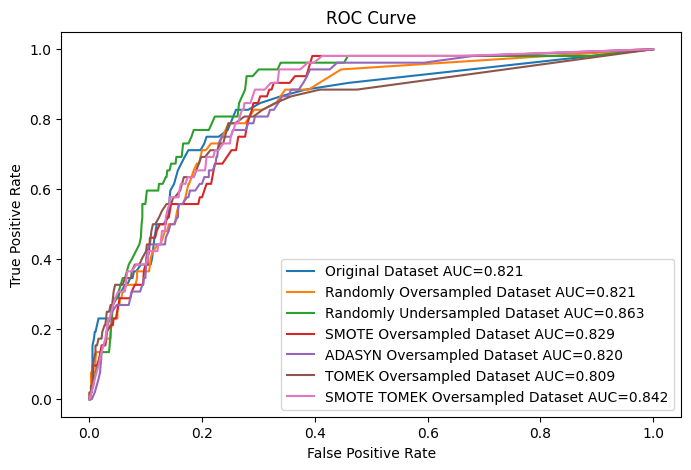

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

# Helper function for plotting ROC
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict_proba(X_test)[:,1]

    #Note that we only use the ROC curve for the test set
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    ax.plot(fpr,tpr,label=f"{title} AUC={auc:.3f}")

    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc=0)

# Plot all ROC into one graph

fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_pca, y_train, X_test_pca, y_test, 'Original Dataset')
plot_roc(ax, X_train_ros, y_train_ros, X_test_pca, y_test, 'Randomly Oversampled Dataset')
plot_roc(ax, X_train_rus, y_train_rus, X_test_pca, y_test, 'Randomly Undersampled Dataset')
plot_roc(ax, X_train_smote, y_train_smote, X_test_pca, y_test, 'SMOTE Oversampled Dataset')
plot_roc(ax, X_train_adasyn, y_train_adasyn, X_test_pca, y_test, 'ADASYN Oversampled Dataset')
plot_roc(ax, X_train_tomek, y_train_tomek, X_test_pca, y_test, 'TOMEK Oversampled Dataset')
plot_roc(ax, X_train_smotetomek, y_train_smotetomek, X_test_pca, y_test, 'SMOTE TOMEK Oversampled Dataset')

Notice that the result is way better than the SVC method for the original data without resampling. This is because Random forest is an ensemble method combining multiple models (decision trees), reducing the effect of imbalanced data.

# **In-Class Activity 1:** Resampling across different ML methods

1. Implement all the above resampling methods for Logistic regression with L2, SVC, Random Forest, XGBoost, and Decision Tree. Summarize your results in a table, and provide three highlights. Aside from AUC, you can think about accuracy, precision, and recall with run time.

2. Compare your highlights with your LT, and come up with five most important insights. Be ready to share your group results in class.

# **In-Class Activity 2:** Fraud in Card Credit Data Set

Data was sampled (10%) of data here: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud. Data is shared in ALICE as "credit_card.csv".

The dataset contains transactions made by credit cards in September 2013 by European cardholders. The total dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA is 'Amount'. 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Your Task in Class: Implement kNN, Logistic Regression, Decision Tree, Random Forest, Gradient Boosting Classifier with their default parameters and compare the Recall of the test set data using stratified k_fold 5 splits (skf = StratifiedKFold(n_splits=5)).

In [64]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Teaching/ML2_MSDS2025PTB/Notebook2_ClassImbalance/'

Mounted at /content/drive


In [65]:
df = pd.read_csv(data_dir + 'credit_card.csv')
df.head(3)

V1        V2        V3        V4        V5        V6        V7  \
0 -0.611712 -0.769705 -0.149759 -0.224877  2.028577 -2.019887  0.292491   
1 -0.814682  1.319219  1.329415  0.027273 -0.284871 -0.653985  0.321552   
2 -0.318193  1.118618  0.969864 -0.127052  0.569563 -0.532484  0.706252   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0 -0.523020  0.358468  0.070050  ... -0.075208  0.045536  0.380739  0.023440   
1  0.435975 -0.704298 -0.600684  ... -0.128619 -0.368565  0.090660  0.401147   
2 -0.064966 -0.463271 -0.528357  ... -0.305402 -0.774704 -0.123884 -0.495687   

        V25       V26       V27       V28  Amount  Class  
0 -2.220686 -0.201146  0.066501  0.221180    1.79      0  
1 -0.261034  0.080621  0.162427  0.059456    1.98      0  
2 -0.018148  0.121679  0.249050  0.092516    0.89      0  

[3 rows x 30 columns]

In [66]:
len(df)

28481

Checking the distribution

Not fraud:  28432
Fraud:      49


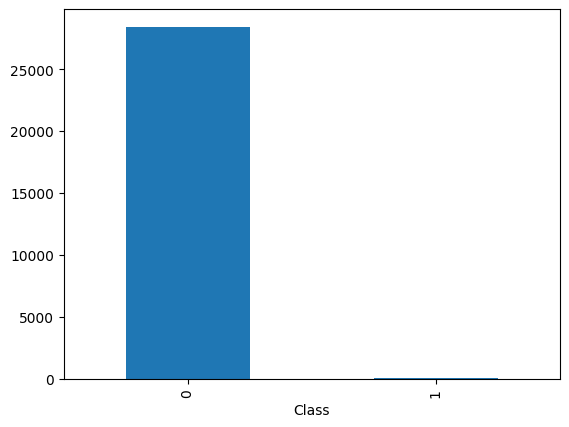

In [67]:
print(f"Not fraud:  {df.Class.value_counts()[0]}")
print(f"Fraud:      {df.Class.value_counts()[1]}")
df['Class'].value_counts().plot.bar();

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random

import warnings
warnings.filterwarnings("ignore")

In [69]:
X, y = df.drop('Class', axis=1), df['Class']

def plot_3d(X, y, title):
# Create a scatter plot
    fig = px.scatter_3d(X,
                        x='V1',
                        y='V2',
                        z='V3',
                        color=y,
                        opacity =0.6,
                        title = title)
    fig.update_layout(showlegend=False)

    # Show the plot
    fig.show()

In [70]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    random_state=143)

In [71]:


plot_3d(X_train, y_train, "Original Scatterplot of the Train Set")

Let's use undersampling

In [72]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Perform random oversampling
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Perform random oversampling
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

In [73]:
plot_3d(X_train_rus, y_train_rus, "Undersampled Scatterplot of the Train Set")

In [74]:
plot_3d(X_train_ros, y_train_ros, "Oversampled Scatterplot of the Train Set")

Output hidden; open in https://colab.research.google.com to view.

#3. Conclusion

In conclusion, handling imbalanced datasets is a critical aspect of machine learning and data analysis. There is no one-size-fits-all solution, and the best approach often requires experimentation and a deep understanding of the problem domain. Proper evaluation and careful consideration of the chosen metrics are key to building effective models on imbalanced data.

The following presents other techniques that either presents an entirely new approach from what we discussed or some modifications to suit other scenarios (e.g. improvements to SMOTE/ADASYN). As there is quite a host of studies relating to class imbalance, this list is not exhaustive and is based primarily on some implementations available at `imblearn`. *Note: Description column is delibrately left out for your exercise.*

|Name|Source|Description|
|--|--|--|
|[BorderlineSMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html)|[Han, et al (2005)](https://doi.org/10.1007/11538059_91)|xxx|
|[SVMSMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SVMSMOTE.html)|[Nguyen et al (2009)](https://ousar.lib.okayama-u.ac.jp/files/public/1/19617/20160528004522391723/IWCIA2009_A1005.pdf)|xxx|
|[KMeansSMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.KMeansSMOTE.html)|[Last, et al (2017)](https://doi.org/10.1016/j.ins.2018.06.056)|xxx|
|[SMOTENC](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html)|[Chawla, et al (2002)](https://doi.org/10.1613/jair.953)|xxx|
|[SMOTEN](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTEN.html)|[Chawla, et al (2002)](https://doi.org/10.1613/jair.953)|xxx|
|[NearMiss](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html)|[Mani & Zhang (2003)](https://www.site.uottawa.ca/~nat/Workshop2003/jzhang.pdf)|xxx|
|[TomekLinks](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.TomekLinks.html)|[Tomek (1976)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4309523)|Discussed in class.|
|[EditedNearestNeighbours](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html)|[Wilson 1972](https://sci2s.ugr.es/keel/dataset/includes/catImbFiles/1972-Wilson-IEEETSMC.pdf)|xxx|
|[RepeatedEditedNearestNeighbors](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RepeatedEditedNearestNeighbours.html)|[Tomek (1976)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4309523)|xxx|
|[AllKNN](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.AllKNN.html)|[Tomek (1976)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=4309523)|xxx|
|[SMOTETomek](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html)|[Batista, et al (2004)](https://doi.org/10.1145/1007730.1007735)|Discussed in class.|
|[SMOTEENN](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html)|[Batista, et al (2003)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.10.2192&rep=rep1&type=pdf)|xxx|


Aside from resampling other methods of addressing the modeling problem due to imbalanced data set includes:

**Cost-Sensitive Learning:** Assigning different misclassification costs to classes to make the model more sensitive to minority class errors.

**Ensemble Methods:** Using ensemble techniques like Random Forests and Gradient Boosting, which can handle class imbalance effectively by combining multiple models. You know this by heart by now.

**Using Anomaly Detection method:** Treating the minority class as anomalies and using anomaly detection algorithms like One-Class SVM or Isolation Forest. This is a method you can easily learn on your own. **Learn this method!**

**Algorithmic Adjustments:** Modifying algorithms to give more importance to the minority class during training, e.g., by adjusting class weights.

**Changing the Evaluation Metrics:** Utilizing appropriate evaluation metrics such as precision, recall, F1-score, and ROC-AUC that provide a more accurate reflection of model performance in imbalanced scenarios.



#Appendix1:  ROC Curve

Taken from https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=An%20ROC%20curve%20


An ROC curve (Receiver Operating Characteristic curve) is a graphical representation used to evaluate the performance of a classification model across different classification thresholds. The ROC curve was first developed by electrical engineers and radar engineers during World War II for detecting enemy objects in battlefields, starting in 1941, which led to its name ("Receiver Operating Characteristic"). It was soon introduced to psychology to account for perceptual detection of stimuli.

This curve illustrates two essential parameters:

In [75]:
import numpy as np
from tabulate import tabulate

# Example ground truth values (actual) and predicted values
actual = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
predicted = np.array([1, 0, 1, 1, 1, 0, 0, 1, 1, 0])

# Calculate True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)
tp = np.sum((actual == 1) & (predicted == 1))
tn = np.sum((actual == 0) & (predicted == 0))
fp = np.sum((actual == 0) & (predicted == 1))
fn = np.sum((actual == 1) & (predicted == 0))

# Create a table
table = [
    ["", "Actual Positive", "Actual Negative"],
    ["Predicted Positive", f'TP: {tp}', f'FP: {fp}'],
    ["Predicted Negative", f'FN: {fn}', f'TN: {tn}']
]

# Display the table using tabulate
table_str = tabulate(table, headers="firstrow", tablefmt="grid")

# Print the table
print(table_str)


+--------------------+-------------------+-------------------+
|                    | Actual Positive   | Actual Negative   |
+====================+===================+===================+
| Predicted Positive | TP: 4             | FP: 2             |
+--------------------+-------------------+-------------------+
| Predicted Negative | FN: 1             | TN: 3             |
+--------------------+-------------------+-------------------+



1. **True Positive Rate (TPR):** Also known as recall or sentivity, TPR represents the proportion of true positive predictions out of all actual positive cases. It is defined as follows:

$$TPR = \frac{True\ Positives}{True\ Positives + False\ Negatives}$$

2. **False Positive Rate (FPR):** FPR quantifies the proportion of false positive predictions out of all actual negative cases. It is 1 - **Specificity** (note: Specificity = $\frac{TN}{TN+FP})$. It is defined as follows:

$$FPR = \frac{False\ Positives}{False\ Positives + True\ Negatives}$$

\\
An ROC curve plots the TPR against the FPR for various classification thresholds. By adjusting the classification threshold, you can control the trade-off between identifying more true positives and incurring more false positives. Lowering the threshold tends to increase both True Positives and False Positives.

Below is a typical ROC curve for reference:

<p align="center">
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/Roc-draft-xkcd-style.svg/800px-Roc-draft-xkcd-style.svg.png" alt="ROC Curve" width="800"/>
</p>
This curve helps assess and visualize how well a classification model discriminates between positive and negative classes across different decision boundaries.

For interpretation we use the AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve. It is one of the most important evaluation metrics for checking any classification model’s performance. It is also written as AUROC (Area Under the Receiver Operating Characteristics). Here is a good reference to fully appreciate this measurement: https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

# Assignment 2 Resampling for Class Imbalanced Data Set (per SLT, 20 pts, due: 18 October 2024, 11:59 pm)

You can download the complete two-day credit card data here: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud. Compare the results of performing the six resampling techniques described in Notebook 3. Measure the accuracy using the Area Under the Precision-Recall Curve (AUPRC --- READ AND LEARN THIS!). Again, note that confusion matrix accuracy is not meaningful for this problem. Provide 5 highlights based on your results.